In [1]:
import numpy as np
import pylab as plt
import os

from functions import *
from line_cross_standard_utilities import *
from line_cross_tensorflow_prediction_utilities import *

plt.rc('image', cmap='plasma') 

In [2]:
def accuracy(gt, pred, mask):

    gap_true = gt*mask
    gap_pred = pred*mask
    
    acc = (1 - np.sum(np.abs(gap_true-gap_pred))/np.sum(gap_true))*100
    if acc<0:
        acc = 0
    
    return acc

# Load one data

In [3]:
path = '/data/id01/inhouse/bellec/software/sharedipynb/Matteo/experimental_data/EB_clean_experimental_dataset/EB_random_sizes_clean_experimental_data/20230124_hc4050_richard_Particle_1_dataset_Pt_0019_scan_43.npz'


In [4]:
path_a = '/data/id01/inhouse/bellec/software/sharedipynb/Matteo/experimental_data/EB_clean_experimental_dataset/EB_random_sizes_clean_experimental_data/HC4050_LTP_Richard_Pd_20230607_dataset_sample_BCDI_0004_scan_15.npz'
path_b = '/data/id01/inhouse/bellec/software/sharedipynb/Matteo/experimental_data/EB_clean_experimental_dataset/EB_random_sizes_clean_experimental_data/HC4959_Chatelier_dataset_B18S2P1_0001_scan_25.npz'
path_c= '/data/id01/inhouse/bellec/software/sharedipynb/Matteo/experimental_data/EB_clean_experimental_dataset/EB_random_sizes_clean_experimental_data/HC5362_Grimes_Pd_20231025_dataset_PdGC1_0001_scan_11.npz'
pathw = '/data/id01/inhouse/bellec/software/sharedipynb/Matteo/experimental_data/EB_clean_experimental_dataset/EB_random_sizes_clean_experimental_data/HC5362_Grimes_Pd_20231025_dataset_PdGC5_BCDI_0005_scan_3.npz'


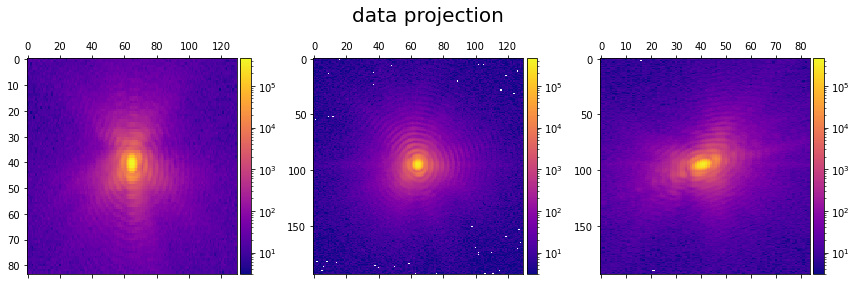

In [14]:

path1 = '/data/id01/inhouse/bellec/software/sharedipynb/Matteo/experimental_data/20230124_hc4050_richard/experimental_data/Particle_1/dataset_Pt_0019_scan_35.npz'
path2 =  '/data/id01/inhouse/bellec/software/sharedipynb/Matteo/experimental_data/Looking_for_experimental_data/corentin_202211_Pd_preprocessed/S13_preprocessing_norm_128_128_128_1_1_1.npz'
path3 = '/data/id01/inhouse/bellec/software/sharedipynb/Matteo/experimental_data/ML_Zhong_Zhuang_ESRF/Pt_111_no_defect_S885_orthonormalised_binning_1_1_1_size_128_128_128.npy'
path4 = "/data/id01/inhouse/bellec/software/sharedipynb/CEA_post_doc_experiment/Richard_IHHC3936/BCDI_reconstruction/preprocessed_data_PtYSZ/dataset_PtYSZ_0001_scan_54.npz"
path5 = '/data/id01/inhouse/bellec/software/sharedipynb/Matteo/Detector_gap/3D_prediction/Matteo_tests/Jerome_Carnis/BCDI_reconstruction/preprocessed_data_s7/dataset_S2227_scan_2227.npz'
path6 = '/data/id01/inhouse/bellec/software/sharedipynb/Python_tests/Matthieu/BCDI_reconstruction/preprocessed_data_B18S2P1/dataset_B18S2P1_0033_scan_12_HighRes.npz'

# data = 1e6*np.load(path3)

data_full = np.load(pathw)
# data = data_full['data']
# mask = data_full['mask']

data = data_full['I']


plot_3D_projections(data, log_scale=True, fig_title='data projection')

## Rotate the image to have the cross on the z plane

In [168]:
# data = np.swapaxes(data,1,2)
# # data = np.rot90(data,-1)
# # mask = np.swapaxes(mask,0,2)
# plot_3D_projections(data, log_scale=True, fig_title='data projection')

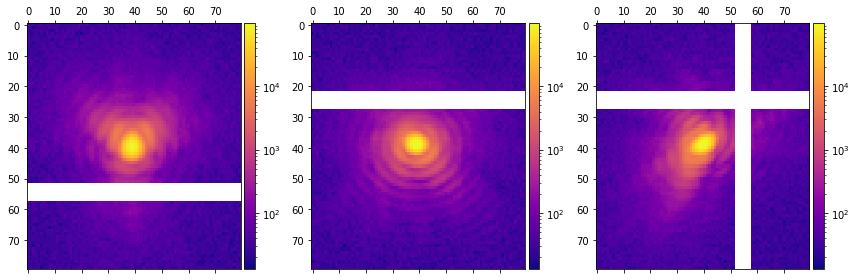

In [170]:
mask = add_cross_gap3D(data, gap_size = 6, gap_position = 55, min_distance_from_center = 0)
data_masked_linear = data*(1.-mask)
plot_3D_projections(data_masked_linear, log_scale = True)

# Data pre-processing

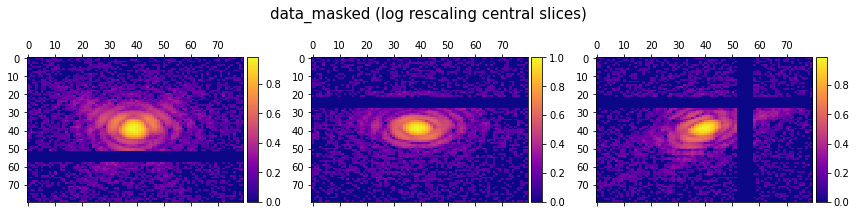

In [171]:
data_masked, maxi_rescale1, maxi_rescale2 = data_preprocessing(data_masked_linear)
plot_central_slices(data_masked, fig_title='data_masked (log rescaling central slices)')

# Find gap parameters automatically

In [172]:
gap_params = find_gap_parameters(mask, verbose=True)

gap_shape : cross
axis_parallel : 2
gap_size : 6
mask_position : [24. 54. nan]
pixel_masked : [array([22, 23, 24, 25, 26, 27]) array([52, 53, 54, 55, 56, 57]) list([])]


# Load corresponding gap size model

In [198]:
from tensorflow.keras import losses
keras.losses.custom_loss = MyLoss_noisy

model_path = '/data/projects/id01ml/SavedModels/3D_inpainting_portions32_{}px_cross/'.format(gap_params['gap_size'])
print('model path :', model_path)keras.losses.custom_loss = MyLoss_noisy

if os.path.exists(model_path):
    print('This gap size model exists')
    import tensorflow as tf 
    print(tf.__version__)
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    model = tf.keras.models.load_model(model_path, custom_objects=None, compile=False)
    new_model = tf.keras.models.load_model(model_path,custom_objects = {'MyLoss_noisy' :MyLoss_noisy})
    print('Models loading done.')
else:
    print('Error, this gap size model doesn\'t exits yet')

model path : /data/projects/id01ml/SavedModels/3D_inpainting_portions32_6px_cross/
This gap size model exists
2.2.0
Num GPUs Available:  1
Models loading done.


# Fine tuning dataset - crop portions out of the diffraction


In [174]:
# from scipy.stats import multivariate_normal

# def sample_3d_coordinates_with_gaussian(array, scale_factor=1.0):
#     shape = array.shape
#     center = (shape[0] / 2, shape[1] / 2, shape[2] / 2)

#     # Increase the scale by the scale_factor
#     cov_matrix = np.eye(3) * scale_factor

#     mvn = multivariate_normal(mean=center, cov=cov_matrix)

#     while True:
#         sampled_coordinates = mvn.rvs()
#         sampled_coordinates = np.round(sampled_coordinates).astype(int)

#         if all(0 <= coord < dim for coord, dim in zip(sampled_coordinates, shape)):
#             return sampled_coordinates

# # Example usage with a larger scale factor (e.g., 5.0):
# array = np.zeros((10, 10, 10))
# sampled_coords = sample_3d_coordinates_with_gaussian(data_masked, scale_factor=100)
# print("Sampled Coordinates:", sampled_coords)


In [184]:
dataset = create_target_dataset(data, mask, nb_images = int(32*200))
data_gen = create_datagenerator_ft(dataset, gap_size = gap_params['gap_size'])

# Evaluate the loss on the pretrained model with the new dataset

The Fine Tuning works only if the new loss is lower than this one

In [187]:
tot_loss = 0
for i in range(32):
    X,y = data_gen.__getitem__(i)
    y_pred = model(X)
    loss = np.mean(MyLoss_noisy(y,y_pred))
    tot_loss+=loss
print('The pretrained model loss is: ', tot_loss/32)


The pretrained model loss is:  1.8112648278474808


# Secondary training 

In [199]:
loss = MyLoss_noisy
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-7)

loss_train = []
loss_val = []

new_model.compile(optimizer=keras.optimizers.Adam(),
              loss=MyLoss_noisy)

In [200]:
history = new_model.fit(data_gen, epochs=2)

Epoch 1/5
200/200 [==============================] - 30s 148ms/step - loss: 1.5985
Epoch 2/5
200/200 [==============================] - 30s 148ms/step - loss: 1.3849
Epoch 3/5
200/200 [==============================] - 30s 148ms/step - loss: 1.3230
Epoch 4/5
200/200 [==============================] - 30s 148ms/step - loss: 1.2881
Epoch 5/5
200/200 [==============================] - 30s 148ms/step - loss: 1.2757


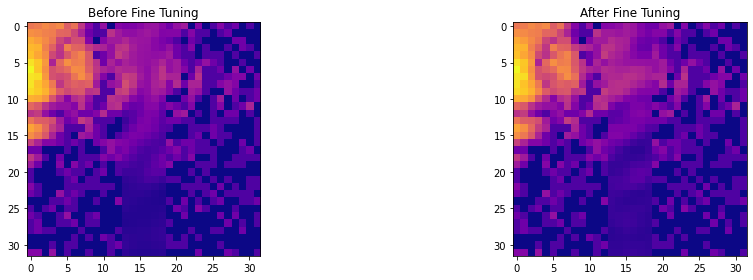

In [206]:
# take a portion with the real gap to see if there is an improvement
Inorm_masked = Inorm*(1.- mask)
gap_pos = int(gap_params['mask_position'][1])+1
lim = np.minimum(Inorm_masked.shape[0],Inorm_masked.shape[2])
rand = np.random.randint(lim//2 -10,lim//2 +10 )

I_gap = Inorm_masked[rand-16:rand+16,gap_pos-16:gap_pos+16, rand-16:rand+16] # crop a portion at random position along the gap

I_test = np.reshape(I_gap, (1,32,32,32,1))

out1 = model(I_test)[0,...,0] 
mask2 = mask[rand-16:rand+16,gap_pos-16:gap_pos+16, rand-16:rand+16]
oout1 = out1*mask2 + I_gap

out2 = new_model(I_test)[0,...,0] 
mask2 = mask[rand-16:rand+16,gap_pos-16:gap_pos+16, rand-16:rand+16]
oout2 = out2*mask2 + I_gap

fig,ax = plt.subplots(1,2,figsize=(16,4))

ax[0].imshow(oout1[:,:,16])
ax[1].imshow(oout2[:,:,16])
ax[0].set_title('Before Fine Tuning')
ax[1].set_title('After Fine Tuning')
fig.tight_layout()

# Make prediction

In [197]:
# skip_pixels = 
skip_pixels = 0
prediction = gap_prediction(data_masked, mask, gap_params, model,
                   skip_pixels=skip_pixels)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 48 48 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 48 48 

In [34]:
# skip_pixels = 
skip_pixels = 0
prediction_2 = gap_prediction(data_masked, mask, gap_params, model,
                   skip_pixels=skip_pixels)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 39 39 

# Make the postprocessing

In [207]:
prediction_linear = post_processing_prediction(prediction, maxi_rescale1, maxi_rescale2)
# prediction_linear2 = post_processing_prediction(prediction_2, maxi_rescale1, maxi_rescale2)

# Check prediction

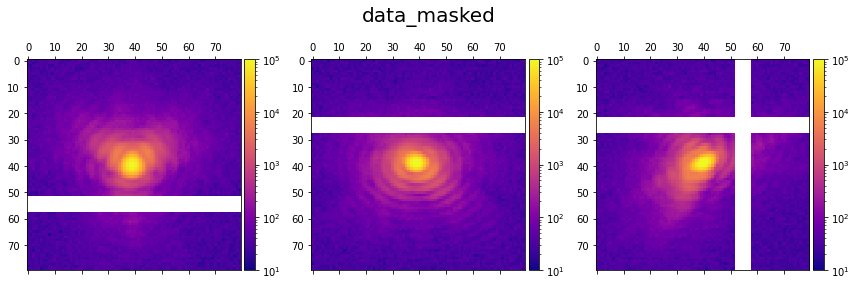

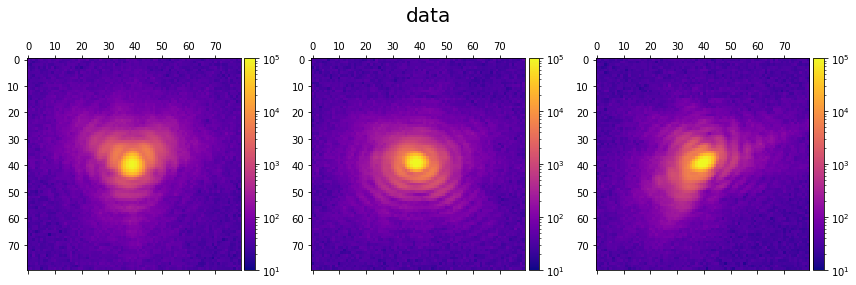

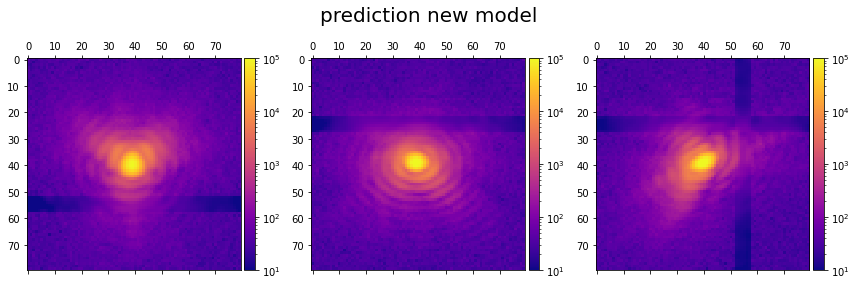

In [209]:
vmin = 10
vmax = 1e5
plot_3D_projections(data_masked_linear, log_scale=True,vmin=vmin, vmax=vmax, fig_title='data_masked')
plot_3D_projections(data, log_scale=True,vmin=vmin, vmax=vmax, fig_title='data')
plot_3D_projections(prediction_linear, log_scale=True,vmin=vmin, vmax=vmax, fig_title='prediction new model')